In [16]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr #import pandas datareader

import yfinance as yf # you will need to install it if haven't done it already

#override the data reader function

yf.pdr_override()

In [17]:
#pip install pandas_datareader

In [18]:
def generate_stock_data(stocks,start,end):
    stocks_data = pdr.get_data_yahoo(stocks,start,end)
    stocks_data = stocks_data['Close']
    returns = stocks_data.pct_change()
    mean_returns = returns.mean()
    covariance_mat = returns.cov()
    return mean_returns,covariance_mat

In [19]:
stock_collection = ['BA', 'JPM', 'META', 'NIO']
stocks = [stk  for stk in stock_collection]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=300)

In [20]:
mean_returns , covariance_mat = generate_stock_data(stocks,start_date,end_date)
print(mean_returns)
print(covariance_mat)

[*********************100%***********************]  4 of 4 completed
BA      0.003329
JPM     0.001973
META    0.004763
NIO     0.000909
dtype: float64
            BA       JPM      META       NIO
BA    0.000420  0.000119  0.000120  0.000318
JPM   0.000119  0.000264  0.000111  0.000258
META  0.000120  0.000111  0.001238  0.000562
NIO   0.000318  0.000258  0.000562  0.002533


In [21]:
#weights for the portfolio 
weights = np.random.random(len(mean_returns))# it returns num b/w [0,1]
weights /= np.sum(weights)
print(weights)

[0.09345517 0.26426246 0.20172669 0.44055569]


In [26]:
#MC Simulation method
num_mc_sims = 1000
t_f=100# 100 day timeframe

mean_returns_matrix_tf = np.full(shape=(t_f,len(weights)), fill_value=mean_returns)
mean_returns_matrix_tf=mean_returns_matrix_tf.T
portfolio_matrix_sims = np.full(shape=(t_f,num_mc_sims), fill_value=0.0)

"""
Here for daily returns we are using Cholesky decomposition method, 
when  we assume there is a multivariate
normal distribution 
"""
intital_protfolio_val = 10
for m in range(0,num_mc_sims):
    #MC iterations
    z = np.random.normal(size=(t_f,len(weights))) #samples for a normal distribution 
    l = np.linalg.cholesky(covariance_mat) #Lower traiangular matrix from Cholesky decomposition
    
    daily_ret = mean_returns_matrix_tf + np.inner(l,z)# daily returns correlated for individual stocks
    portfolio_matrix_sims[:,m] = np.cumprod(np.inner(weights,daily_ret.T))*intital_protfolio_val # portfolio for eah day 
    

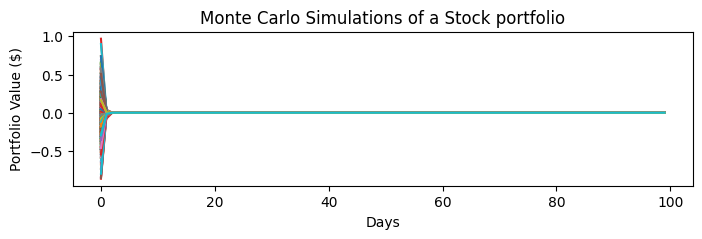

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
plt.plot(portfolio_matrix_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulations of a Stock portfolio')
plt.show()

In [11]:
""" as the number of simulations increases, 
the computation required to complete the method increases, 
you are aiming for a convergence to the ‘exact’ solution """

' as the number of simulations increases, \nthe computation required to complete the method increases, \nyou are aiming for a convergence to the ‘exact’ solution '

In [12]:
#Finding Var and CVar

In [29]:
def mc_var(returns, alpha=5):
    """
    returns : pandas series of returns
    alpha: confidence leel
    o/p: percentile on return distribution for given alpha
    """
    if isinstance(returns,pd.Series):
        return np.percentile(returns,alpha)
    else:
        raise TypeError("Not a pandas series")
#expected shortfall beyond the calculated loss        
def mc_cvar(returns, alpha=5):
    """
    returns : pandas series of returns
    alpha: confidence leel
    o/p: expected shortfall for given alpha
    """
    if isinstance(returns,pd.Series):
        below_var = returns <= mc_var(returns,alpha=alpha)#subsection of returns 
        return returns[below_var].mean()
    else:
        raise TypeError("Not a pandas series")  
        

        

In [30]:
portfolio_results = pd.Series(portfolio_matrix_sims[-1,:])#intesretd in last step T =100th
var = intital_protfolio_val -  mc_var(portfolio_results,alpha=5)
cvar = intital_protfolio_val - mc_var(portfolio_results,alpha=5)

In [31]:
print('Value at Risk ${}'.format(round(var,2)))
print('Conditional Value at Risk ${}'.format(round(cvar,2)))

Value at Risk $10.0
Conditional Value at Risk $10.0
